In [18]:
import torch, re, os
from datetime import datetime as dt
from datetime import timedelta as td
from torch.autograd import Variable
import matplotlib.pyplot as plt
import quandl as qdl
import numpy as np
import pandas as pd
from os.path import abspath
from inspect import getsourcefile
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import BDay
from pandas.tseries.offsets import CustomBusinessDay

In [19]:
def file_iterator(rootdir):
    files = []
    f = []
    g = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file[-3:] == "csv":
                f.append(os.path.join(subdir, file))
                g.append(file[:-4])
    return(f, g)

In [90]:
import torch, re,os
from datetime import datetime as dt
from datetime import timedelta as td
from torch.autograd import Variable
import matplotlib.pyplot as plt
import quandl as qdl
import numpy as np
import pandas as pd
from os.path import abspath
from inspect import getsourcefile
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import BDay
from pandas.tseries.offsets import CustomBusinessDay

def file_iterator(rootdir):
    files = []
    f = []
    g = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file[-3:] == "csv":
                f.append(os.path.join(subdir, file))
                g.append(file[:-4])
    return(f, g)
  
  
class data:
    def __init__(self, quandl_key, data_type = ["SP400"], s_d = dt.today(), e_d = dt(2018, 3, 27, 0, 0), from_end =  3*365):
        
        self.qdl_key = quandl_key
        self.end_date = e_d
        self.data_type = data_type

        if s_d < e_d :
            self.start_date = s_d
        else:
            self.start_date = self.end_date - td(days = from_end)
        
    def get_data_daily_rand(self , num_use = 10000, path_use = "",column_name = "Ticker"):
      #column_name = "ACT Symbol" for SP500
      #column_name = "Ticker" for SP400
        
        qdl.ApiConfig.api_key = self.qdl_key
        
        if path_use == "":
            pl = abspath('/content/csc421/project/data')+'/'
        else:
            pl = abspath(path_use)
        
        cd = re.split(r'\<', pl)[0]
        print(cd)
        t = 0
        splitty = 0
        f_it = file_iterator(cd)
        for j in f_it[0]:
            if f_it[1][splitty] in self.data_type:
                tickers = pd.read_csv(j)[column_name]
                num_samp = min(len(tickers), num_use)
                tickers = tickers[np.random.choice(len(tickers),num_samp, replace = False)]
                tickers = tickers
                for i in tickers:
                    t += 1
                    beg_d = self.start_date.strftime("%Y-%m-%d")
                    end_d = self.end_date.strftime("%Y-%m-%d")
                    if t == 1 :
                        data_use = qdl.get_table("WIKI/PRICES",
                                   qopts={"columns":["date","ticker","open","low","high","close","adj_close","volume"]},
                                   ticker= i, 
                                   date = {'gte': beg_d,'lte' : end_d})
                        data_use = data_use.set_index(["date"], drop=True)    

                    else:
                        temp = qdl.get_table("WIKI/PRICES",
                                   qopts={"columns":["date","ticker","open","low","high","close","adj_close","volume"]},
                                   ticker= i, 
                                   date = {'gte': beg_d,'lte' : end_d})
                        temp = temp.set_index(["date"], drop=True)

                        tot = [data_use, temp]
                        data_use = pd.concat(tot)
                
                if (t/num_samp *100 % 20) == 0:
                    print(t/len(tickers))
        
            splitty += 1
            print(splitty/len(f_it[0]))
        self.data_got_rand = data_use 
        
    def get_data_daily_specific(self, ticker_use):
      
        self.ticker_main = ticker_use
        self.ticker_main = ticker_use
        qdl.ApiConfig.api_key = self.qdl_key

        beg_d = self.start_date.strftime("%Y-%m-%d")
        end_d = self.end_date.strftime("%Y-%m-%d")

        data_use = qdl.get_table("WIKI/PRICES",
                                   qopts={"columns":["date","ticker","open","low","high","close","adj_close","volume"]},
                                    ticker= self.ticker_main, 
                                   date = {'gte': beg_d,'lte' : end_d})
        self.data_got_specific = data_use.set_index(["date"], drop=True)
        
        
    def set_up_features(self, which_data = "rand",ratio = [60,30,10],num_features = [30], grouping_feature = ["ticker"],
                        TS_feature_set = ["close","open","low","high"], cat_feature = [], order = []):
        """
        
        Will need to add catigorcial feature later for improved implementation
        """
        
        if not (sum(ratio) == 100):
            return "ratio entered is invalid"
        
        if which_data == "rand":
            training_d = self.data_got_rand
        
        elif which_data == "specific":
            training_d = self.data_got_specific
            
        training_d = training_d[TS_feature_set + grouping_feature]
        dd = training_d.groupby(grouping_feature)
        
        
        def make_d(list_x):
            b = list_x[0]
            for c in list_x[1:]:
                b = pd.concat([b.reset_index(), c.reset_index()], 
                              axis =1 ).drop('date', axis = 1).set_index(b.index)
            return b
        
        #create input data set 
        self.dd_x = {a:[[group[feature_type][i : - num_features[0] + i]
                       for i in range(num_features[0])]
                      for feature_type in TS_feature_set]
                   for a,group in dd} 
        dd_wanted_x = {a:
                       torch.cat(tuple([torch.t(torch.FloatTensor(self.dd_x[a][b][0:num_features[0]])).unsqueeze(-1) 
                                        for b in range(4)]),2)  
                       for a in self.dd.keys()}
        
        #create output data set
        self.dd_y = {a:[[group[feature_type][i : - num_features[0] + i]
                       for i in range(num_features[1])]
                      for feature_type in TS_feature_set]
                   for a,group in dd} 
        dd_wanted_y = {a:
                       torch.cat(tuple([torch.t(torch.FloatTensor(self.dd_y[a][b][0:num_features[0]])).unsqueeze(-1) 
                                        for b in range(4)]),2)  
                       for a in self.dd.keys()}

         
        #return data set up as tensors for some fun learning
        self.data_cleaned = [dd_wanted_x, dd_wanted_y]
        
    def as_tensor(self, value):
        torch.tensor(np.asanyarray(self.value))
        
    def get_wide(self, price_type):
        self.d_wide = data_got_rand.pivot(columns="ticker", values= price_type)
        
def save_to_pkl(path, objectname, endname):
  with open(os.path.join(path, endname), 'wb') as f:
    pkl.dump(objectname, f)
        

In [108]:
tuple([ a for a in range(4)])

(0, 1, 2, 3)

In [94]:
qdl_key_implament = "zFoL6yQsQfFgifpzPQFC"
S_P_4 = data(qdl_key_implament, from_end=3*365, data_type = ["SP400"])

In [95]:
S_P_4.get_data_daily_rand(num_use = 10,  path_use = "../Data Sets/Constituent Data/")

/home/sstr/DL4TSD/Data Sets/Constituent Data
0.3333333333333333
0.6666666666666666
1.0
1.0


In [96]:
S_P_4.set_up_features(num_features = [10])

In [ ]:
def  create_x(list_of_ds):
    

In [13]:
torch.tensor(np.asarray(S_P_Data.data_cleaned))

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: double, float, float16, int64, int32, and uint8.

In [301]:
list(S_P_Data.data_cleaned.values())

[            close  close  close  close  close  close  close  close  close  \
 date                                                                        
 2018-03-27  58.27  59.42  57.89  59.69  60.87  60.68  60.97  62.08  61.66   
 2018-03-26  59.42  57.89  59.69  60.87  60.68  60.97  62.08  61.66  61.70   
 2018-03-23  57.89  59.69  60.87  60.68  60.97  62.08  61.66  61.70  62.57   
 2018-03-22  59.69  60.87  60.68  60.97  62.08  61.66  61.70  62.57  62.76   
 2018-03-21  60.87  60.68  60.97  62.08  61.66  61.70  62.57  62.76  63.52   
 2018-03-20  60.68  60.97  62.08  61.66  61.70  62.57  62.76  63.52  61.97   
 2018-03-19  60.97  62.08  61.66  61.70  62.57  62.76  63.52  61.97  61.79   
 2018-03-16  62.08  61.66  61.70  62.57  62.76  63.52  61.97  61.79  62.23   
 2018-03-15  61.66  61.70  62.57  62.76  63.52  61.97  61.79  62.23  61.10   
 2018-03-14  61.70  62.57  62.76  63.52  61.97  61.79  62.23  61.10  60.01   
 2018-03-13  62.57  62.76  63.52  61.97  61.79  62.23  61.10  60

In [18]:
S_P_Data.data_got_rand.head()

,ticker,low,high,close,adj_close,volume
date,,,,,,
2018-03-27,UNP,130.630,134.65,131.30,131.30,3763621.0
2018-03-26,UNP,130.930,133.82,133.00,133.00,4747918.0
2018-03-23,UNP,131.610,136.30,131.94,131.94,3747631.0
2018-03-22,UNP,134.400,137.87,134.87,134.87,3532070.0
2018-03-21,UNP,137.445,140.25,138.56,138.56,3310871.0


In [56]:
from torch import nn
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
        
        )
    
    def forward(self, x, pars):
        pass
    def backprop(self, x, pars):
        pass

In [ ]:
def L_k_norm(x,y,k):
        

class ARIMA:
    def __init__(self, X, Y, n,p,q):
        
        self.x, self.y, self. n, self.p, self.q =  X, Y, n, p, q
        self.run_arima()
    
    def run_arima(self):
        
        

In [62]:
(S_P_Data.data_got_rand.tail()["adj_close"] - S_P_Data.data_got_rand.tail()["adj_close"])**2

date
2016-04-01    0.0
2016-03-31    0.0
2016-03-30    0.0
2016-03-29    0.0
2016-03-28    0.0
Name: adj_close, dtype: float64

ticker
ABBV    Axes(0.125,0.2;0.775x0.68)
ADI     Axes(0.125,0.2;0.775x0.68)
EFX     Axes(0.125,0.2;0.775x0.68)
EMR     Axes(0.125,0.2;0.775x0.68)
GPS     Axes(0.125,0.2;0.775x0.68)
Name: close, dtype: object

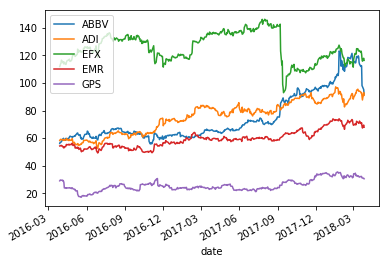

In [58]:
S_P_Data.data_got_rand.groupby('ticker')['close'].plot(legend=True)

In [21]:
S_P_Data.get_data_daily_specific("AAPL")

In [22]:
S_P_Data.data_got_specific.head()

,ticker,low,high,close,adj_close,volume
date,,,,,,
2018-03-27,AAPL,166.92,175.15,168.340,168.340,38962839.0
2018-03-26,AAPL,166.44,173.10,172.770,172.770,36272617.0
2018-03-23,AAPL,164.94,169.92,164.940,164.940,40248954.0
2018-03-22,AAPL,168.60,172.68,168.845,168.845,41051076.0
2018-03-21,AAPL,171.26,175.09,171.270,171.270,35247358.0


In [23]:
S_P_Data.data_got_specific.tail()

,ticker,low,high,close,adj_close,volume
date,,,,,,
2008-04-04,AAPL,150.75,154.715,153.0800,19.672914,30514900.0
2008-04-03,AAPL,147.00,153.630,151.6100,19.483998,37556000.0
2008-04-02,AAPL,145.85,151.200,147.4900,18.954521,37320300.0
2008-04-01,AAPL,143.61,149.660,149.5301,19.216702,36877400.0
2008-03-31,AAPL,142.52,145.710,143.5000,18.441750,27430900.0


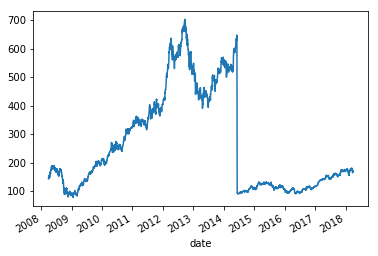

In [24]:
S_P_Data.data_got_specific["close"].plot()